In [1]:
!pip install anndata pandas h5py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
import gzip
import shutil

# Input and output file paths
compressed_file = "GSE199378_series_matrix.txt.gz"
decompressed_file = "GSE199378_series_matrix.txt"

# Decompress the file
with gzip.open(compressed_file, 'rb') as f_in:
    with open(decompressed_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Decompression complete!")


Decompression complete!


In [3]:
import anndata
import pandas as pd

# Load the .h5ad file
adata = anndata.read_h5ad("scRNAseq_oropharyngeal_squamous_cell_carcinoma_cellxgene.h5ad", backed='r')

# Extract data
X = adata.X  # Gene expression matrix (sparse or dense matrix)
obs = adata.obs  # Cell metadata (pandas DataFrame)
var = adata.var  # Gene metadata (pandas DataFrame)


In [9]:
# Count unique labels in development_stage and disease
num_development_stage_labels = adata.obs['development_stage'].nunique()
num_disease_labels = adata.obs['disease'].nunique()
num_cell_type_labels = adata.obs['cell_type'].nunique()

print(f"Number of development_stage labels: {num_development_stage_labels}")
print(f"Number of disease labels: {num_disease_labels}")
print(f"Number of cell labels: {num_cell_type_labels}")
print("cell types", adata.obs['cell_type'])

Number of development_stage labels: 4
Number of disease labels: 2
Number of cell labels: 15


In [5]:
import anndata
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Extract the expression matrix and metadata
X = csr_matrix(adata.X.to_memory())  # Convert to Scipy sparse matrix
X.data = np.log1p(X.data)  # normalize to preserve sparcity

# Extract target variables from adata.obs
y_development_stage = pd.get_dummies(adata.obs["development_stage"], drop_first=False).values
y_cell_type = pd.get_dummies(adata.obs["cell_type"], drop_first=False).values
y_disease = pd.get_dummies(adata.obs["disease"], drop_first=False).values

# Concatenate all target variables into a single array
y = np.concatenate([y_development_stage, y_disease], axis=1) #, y_cell_type two labels only

# Saving label names for reference
development_stage_labels = pd.get_dummies(adata.obs["development_stage"]).columns
cell_type_labels = pd.get_dummies(adata.obs["cell_type"]).columns
disease_labels = pd.get_dummies(adata.obs["disease"]).columns

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Additional metadata for easier interpretation
labels_metadata = {
    "development_stage_labels": development_stage_labels,
    "cell_type_labels": cell_type_labels,
    "source_labels": disease_labels,
}


In [ ]:
print(y_development_stage)
print(development_stage_labels)
print(cell_type_labels)
print(disease_labels)


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.initializers import lecun_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation=LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', 'AUC'])

def scheduler(epoch, lr):
    return lr * 0.95  # Reduce learning rate by 5% every epoch

lr_scheduler = LearningRateScheduler(scheduler)


# Train the model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=55,
                    batch_size=128,
                    callbacks=[lr_scheduler, csv_logger])


Epoch 1/55
518/518 [==============================] - 168s 323ms/step - loss: 0.4234 - accuracy: 0.2518 - auc: 0.9241 - val_loss: 0.3185 - val_accuracy: 0.3519 - val_auc: 0.9814 - lr: 9.5000e-04
Epoch 2/55
518/518 [==============================] - 164s 317ms/step - loss: 0.3147 - accuracy: 0.4204 - auc: 0.9818 - val_loss: 0.2980 - val_accuracy: 0.5062 - val_auc: 0.9842 - lr: 9.0250e-04
Epoch 3/55
518/518 [==============================] - 165s 318ms/step - loss: 0.2818 - accuracy: 0.4716 - auc: 0.9910 - val_loss: 0.2842 - val_accuracy: 0.4190 - val_auc: 0.9869 - lr: 8.5737e-04
Epoch 4/55
518/518 [==============================] - 167s 322ms/step - loss: 0.2628 - accuracy: 0.4838 - auc: 0.9946 - val_loss: 0.2768 - val_accuracy: 0.4897 - val_auc: 0.9890 - lr: 8.1451e-04
Epoch 5/55
518/518 [==============================] - 167s 321ms/step - loss: 0.2519 - accuracy: 0.4883 - auc: 0.9962 - val_loss: 0.2791 - val_accuracy: 0.3767 - val_auc: 0.9862 - lr: 7.7378e-04
Epoch 6/55
518/518 [=====

KeyboardInterrupt: 

In [ ]:
# Save the trained model
model.save("tumor_model")


In [7]:
from tensorflow.keras.models import load_model
import os
os.chdir('/content/drive/MyDrive')
# Load the trained model
model = load_model("tumor_model")


In [8]:
# Evaluate on the test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test AUC: {test_auc:.2f}")

518/518 [==============================] - 11s 20ms/step - loss: 0.3910 - accuracy: 0.6920 - auc: 0.9659
Test Loss: 0.39
Test Accuracy: 0.69
Test AUC: 0.97


In [8]:
import numpy as np

# Predict probabilities
predictions = model.predict(X_test)

# Convert to class indices
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)


518/518 [==============================] - 11s 21ms/step


<ipython-input-21-f947e258b360>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(cell_type_labels))


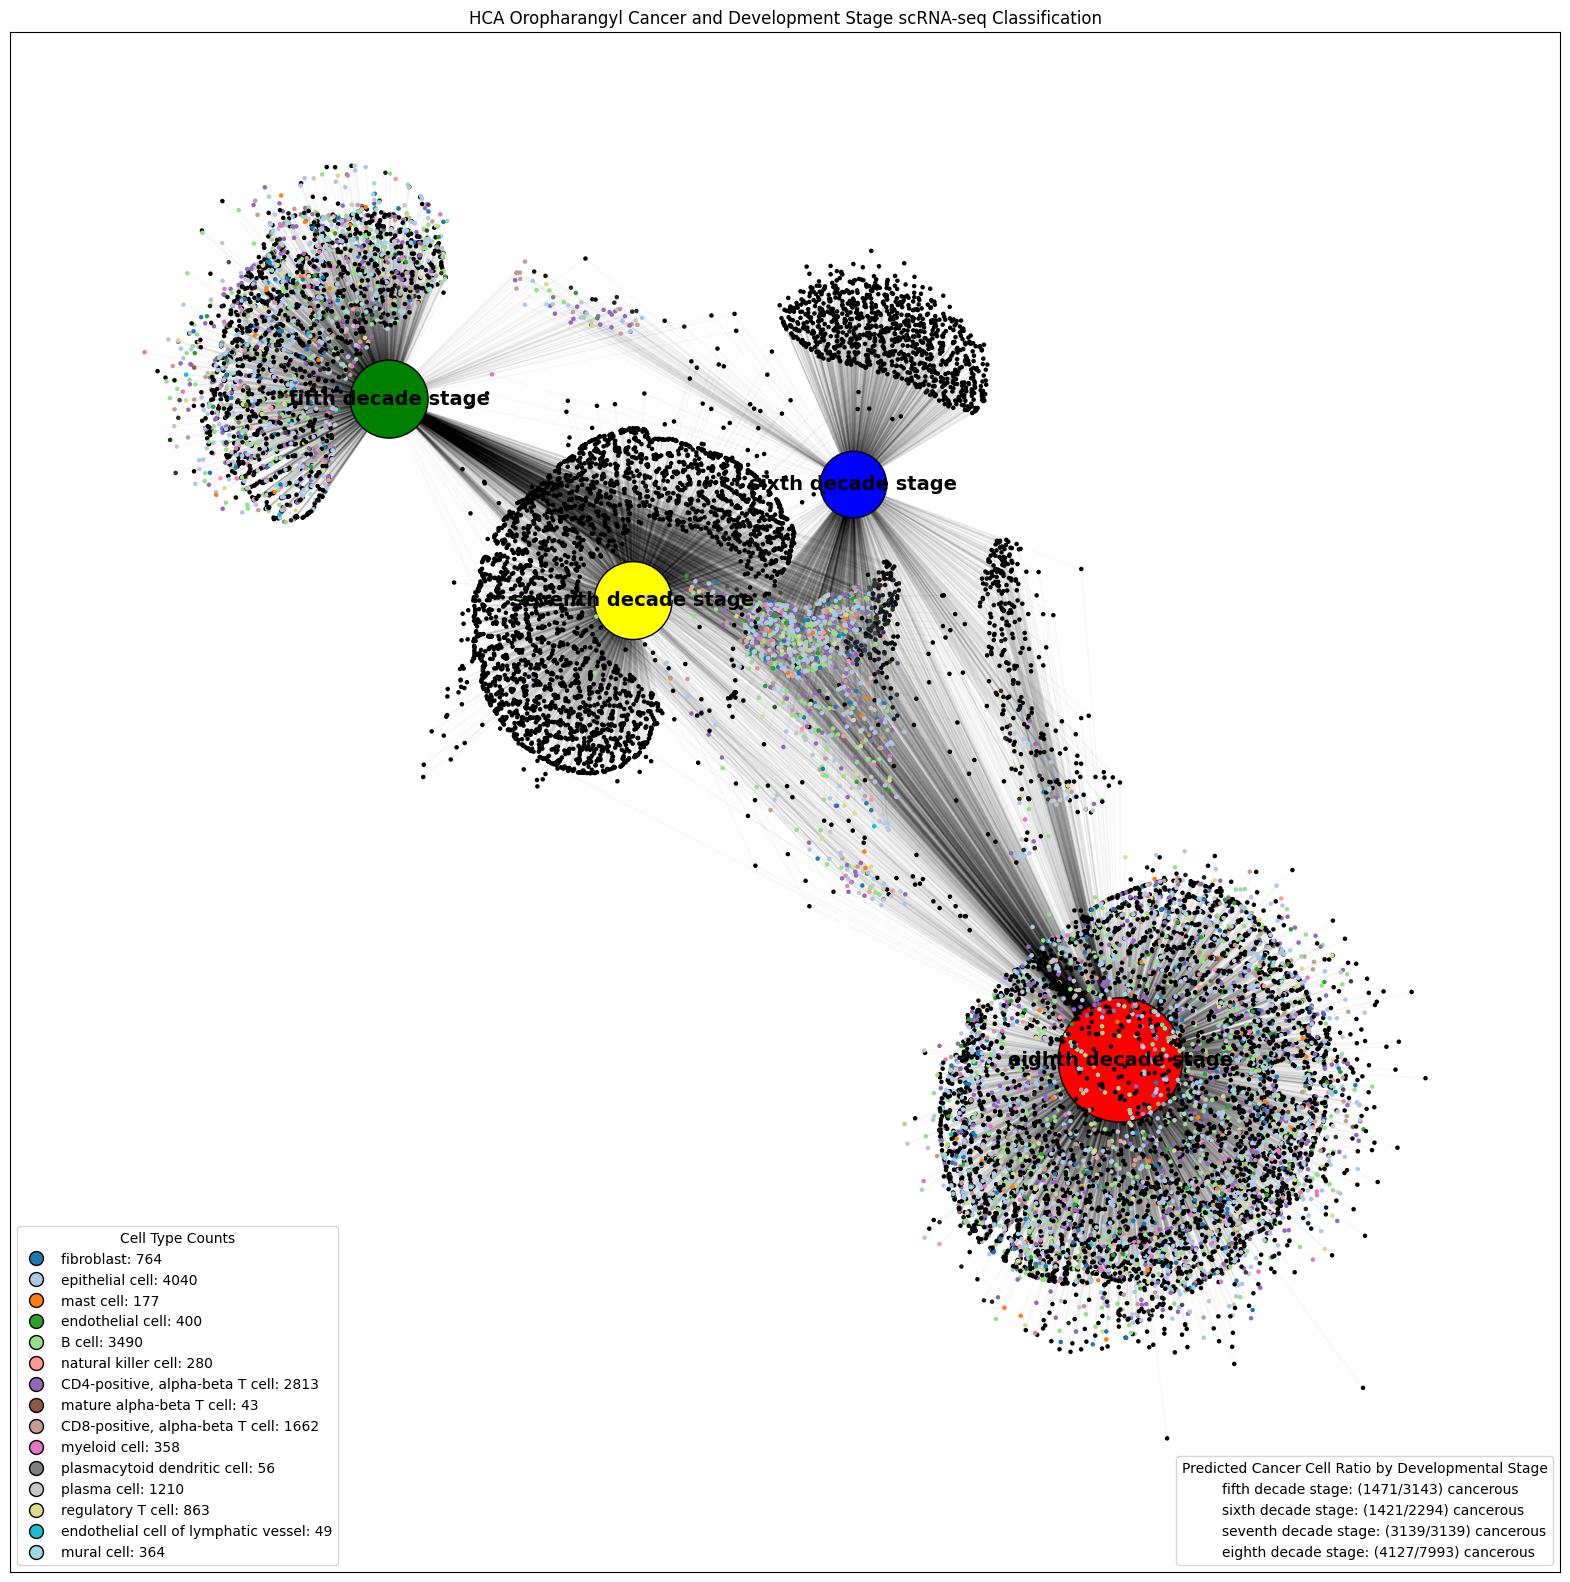

In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

# Color mapping
cmap = cm.get_cmap("tab20", len(cell_type_labels))
cell_type_colors_dict = {cell_type: mcolors.to_hex(cmap(i)) for i, cell_type in enumerate(cell_type_labels)}
cell_type_count_dict = {cell_type: 0 for cell_type in cell_type_labels}
dev_stage_labels_dict = {label: label for label in development_stage_labels}
dev_stage_count_dict = {label: 0 for label in development_stage_labels}
dev_stage_colors_dict = {label:color for label, color in zip(development_stage_labels, ['green','blue','yellow','red'])}
dev_stage_cancer_count_dict = {label: 0 for label in development_stage_labels}
# Initialize Graph
G = nx.Graph()

# Add nodes for each developmental stage
for dev_stage in development_stage_labels:
    G.add_node(dev_stage, type="dev_stage", color=dev_stage_colors_dict)  # Default white

# Add nodes for each cell
for i, prediction in enumerate(predictions):
    # Add a node for each cell
    cell_node = f"Cell_{i}"
    G.add_node(cell_node, type="cell")

    # Determine the strongest developmental stage
    dev_stage_inference_weights = prediction[0:4]
    dev_stage_idx = np.argmax(dev_stage_inference_weights)
    dev_stage = development_stage_labels[dev_stage_idx]
    dev_stage_count_dict[dev_stage] += 1

    # Map disease state
    disease_inference_weights = prediction[4:6]
    disease_idx = np.argmax(disease_inference_weights)
    predicted_disease_inference_value = disease_inference_weights[disease_idx]

    # Retrieve cell type
    cell_type_idx = np.argmax(y_cell_type[i])
    cell_type = cell_type_labels[cell_type_idx]
    cell_type_count_dict[cell_type] += 1
    cell_color = cell_type_colors_dict[cell_type]


    # Darken color for disease prediction proportionally
    if disease_idx == 0:  # Disease-positive condition
        rgb_color = mcolors.to_rgb(cell_color)  # Convert base color to RGB
        cell_color = tuple([c * (1 - predicted_disease_inference_value) * 0.9 for c in rgb_color])

        #record cancr predictions per dev stage
        dev_stage_cancer_count_dict[dev_stage] += 1

    # Assign color as node attribute
    G.nodes[cell_node]["color"] = cell_color

    # Add edges between cells and developmental stage nodes
    for j, strength in enumerate(dev_stage_inference_weights):
        if strength > 0.10:  # Threshold for edge creation
            G.add_edge(cell_node, development_stage_labels[j], weight=strength)

# Compute positions for nodes
positions = nx.spring_layout(G, weight="weight", seed=5, k=0.01, iterations=25)

# Extract node colors dynamically
node_colors = [G.nodes[node].get("color", "gray") for node in G.nodes]

plt.figure(figsize=(20, 20))

#drawing developmental_state nodes first
dev_stage_nodes = [node for node in development_stage_labels if node in G.nodes]

# Get node sizes proportionate to cell counts
dev_stage_sizes = [dev_stage_count_dict[node] for node in dev_stage_nodes]  # Scale counts for visibility

nx.draw_networkx_nodes(
    G,
    positions,
    nodelist=[label for label in dev_stage_labels_dict.values()],
    node_color=[color for color in dev_stage_colors_dict.values()],
    edgecolors="black",
    node_size=dev_stage_sizes,
    label="Development Stage Nodes"
)

# Add labels for developmental stage nodes
nx.draw_networkx_labels(
    G,
    positions,
    labels=dev_stage_labels_dict,  # Dictionary mapping nodes to labels
    font_size=14,
    font_weight="bold",
    font_color="black"
)

# Draw nodes and edges
nx.draw_networkx_nodes(
    G,
    positions,
    nodelist=[node for node in G.nodes if G.nodes[node]["type"] == "cell"],
    node_color=[G.nodes[node]["color"] for node in G.nodes if G.nodes[node]["type"] == "cell"],
    node_size=5,
    label="Cell Nodes"
)

nx.draw_networkx_edges(
    G,
    positions,
    width=1,
    alpha=0.03)

# Add the first legend for developmental stage cancer ratios
dev_stage_labels = [
    f"{dev_stage}: ({dev_stage_cancer_count_dict[dev_stage]}/{dev_stage_count_dict[dev_stage]}) cancerous"
    for dev_stage in development_stage_labels
]
dev_stage_handles = [
    plt.Line2D([], [], color='none', label=label) for label in dev_stage_labels
]
legend1 = plt.legend(
    handles=dev_stage_handles,
    loc="lower right",
    fontsize=10,
    title="Predicted Cancer Cell Ratio by Developmental Stage"
)

# Add the second legend for cell type counts
cell_type_handles = [
    plt.Line2D(
        [], [],
        marker='o',
        color='none',
        markerfacecolor=cell_type_colors_dict[cell_type],
        markersize=10,
        label=f"{cell_type}: {count}"
    )
    for cell_type, count in cell_type_count_dict.items()
]
legend2 = plt.legend(
    handles=cell_type_handles,
    loc="lower left",
    fontsize=10,
    title="Cell Type Counts"
)

# Add the first legend back to the plot to ensure both are displayed
plt.gca().add_artist(legend1)

plt.title("HCA Oropharangyl Cancer and Development Stage scRNA-seq Classification")

plt.savefig("development_classification.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


In [42]:
plt.savefig("development_classification.png", format="png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>